In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from joblib import Parallel,delayed

import pandas as pd

from itertools import chain

from pathlib import Path

from collections import defaultdict

In [2]:
info1 = pd.read_csv("neuroQWERTY/MIT-CS1PD/GT_DataPD_MIT-CS1PD.csv")
info2 = pd.read_csv("neuroQWERTY/MIT-CS2PD/GT_DataPD_MIT-CS2PD.csv")

In [3]:
labels = {
    key:val for key,val in zip(
        chain(info1["file_1"],info2["file_1"]),
        chain(info1["gt"],info2["gt"]),
    )
}

labels.update({
    key:val for key,val in zip(
        info1["file_2"],
        info1["gt"],
    )
})

In [4]:
data_path = Path("features")
data_path1 = data_path/"MIT-CS1PD"
data_path2 = data_path/"MIT-CS2PD"

In [5]:
def _extract_a_dataset(data_path):
    df = Parallel(n_jobs=-2)(
        delayed(
            lambda path:(path.name,pd.read_csv(path))
        )(x) for x in data_path.glob("*.csv")
    )
    df = dict(df)

    dataset = {
        "controlled":{"HL":[],"IL":[],"PL":[],"RL":[],"CL":[]},
        "ailed":{"HL":[],"IL":[],"PL":[],"RL":[],"CL":[]}
    }

    for key,val in df.items():
        subset = dataset["ailed"] if labels[key] else dataset["controlled"]
        subset["HL"].append(val["HL"].values.astype("float32"))
        subset["IL"].append(val.loc[1:,"IL"].values.astype("float32"))
        subset["PL"].append(val.loc[1:,"PL"].values.astype("float32"))
        subset["RL"].append(val.loc[1:,"RL"].values.astype("float32"))
        subset["CL"].append(val.loc[1:,"CL"].values.astype("float32"))

    for key in ["HL","IL","PL","RL","CL"]:
        dataset["controlled"][key] = np.concatenate(dataset["controlled"][key])
        dataset["ailed"][key] = np.concatenate(dataset["ailed"][key])
        
    return dataset

In [6]:
def extract_dataset():
    dataset = {
        "d1":_extract_a_dataset(data_path1),
        "d2":_extract_a_dataset(data_path2)
    }

    for key in ["HL","IL","PL","RL","CL"]:
        dataset[key] = np.concatenate(
            (
                dataset["d1"]["controlled"][key],
                dataset["d1"]["ailed"][key],
                dataset["d2"]["controlled"][key],
                dataset["d2"]["ailed"][key],
            )
        )

    return dataset

In [7]:
dataset = extract_dataset()

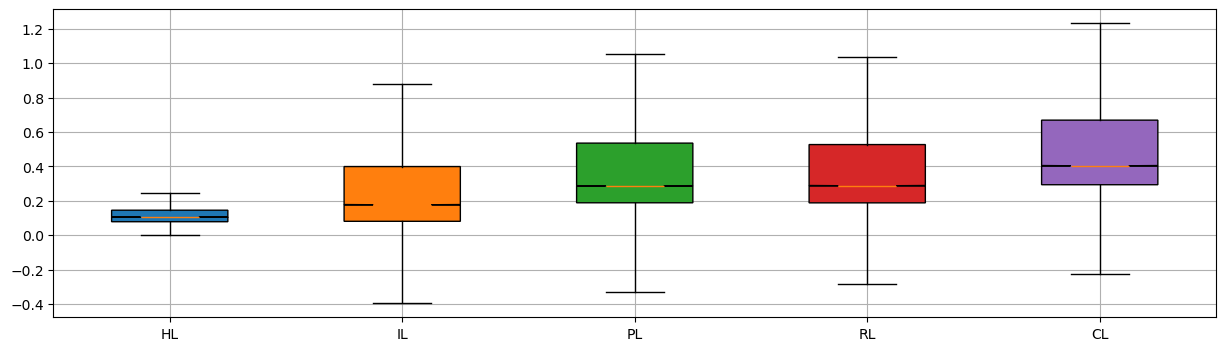

In [8]:
fig,ax = plt.subplots(figsize=(15,4))
ax.grid(True)
bplot = ax.boxplot(
    [dataset[key] for key in ["HL","IL","PL","RL","CL"]],
    notch = True,
    vert=True,  # vertical box alignment
    patch_artist=True,  # fill with color
    labels=["HL","IL","PL","RL","CL"],
    showfliers=False
)  # will be used to label x-ticks

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

In [9]:
type(ax)

matplotlib.axes._axes.Axes

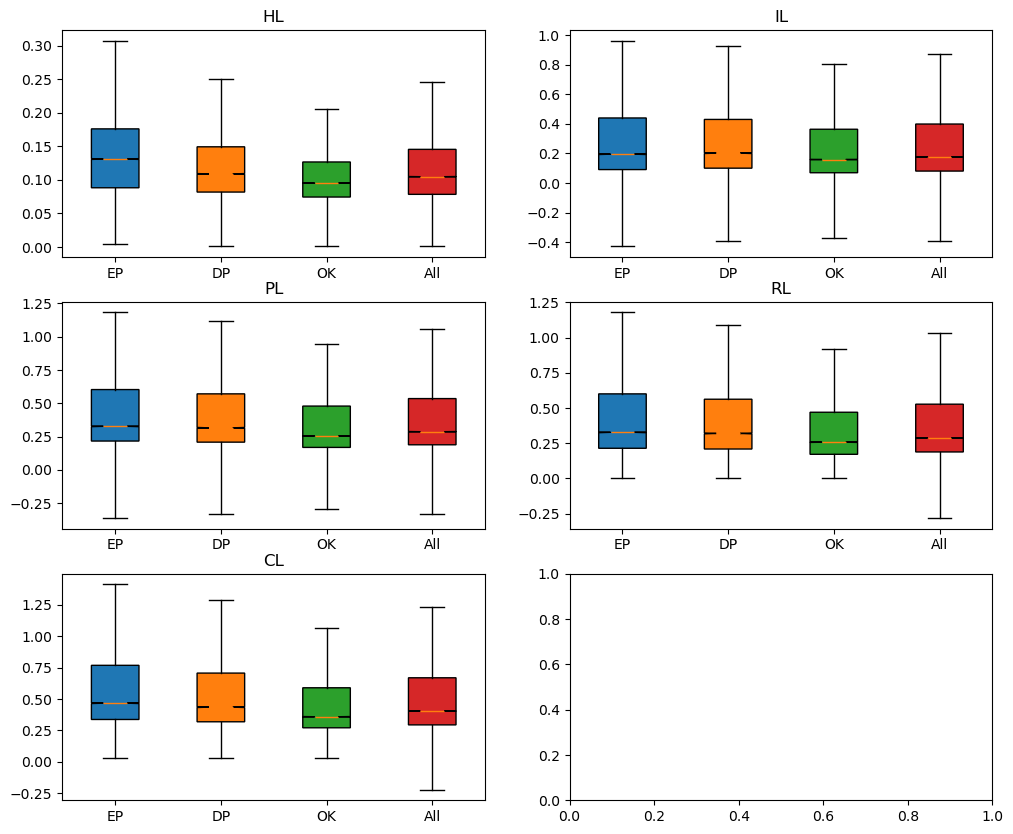

In [10]:
fig,ax = plt.subplots(figsize=(6*2,5*2),nrows=3,ncols=2)

ax = ax.flatten()

for j,key in enumerate(["HL","IL","PL","RL","CL"]):
    bplot = ax[j].boxplot(
        [
            dataset["d1"]["ailed"][key],
            dataset["d2"]["ailed"][key],
            np.concatenate((dataset["d1"]["controlled"][key],dataset["d2"]["controlled"][key])),
            dataset[key]
        ],
        notch = True,
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=["EP","DP","OK","All"],
        showfliers=False
    )  # will be used to label x-ticks
    ax[j].set_title(key)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [11]:
class Percentile:
    def __init__(self,input):
        self.input = np.sort(input)
        self._IQR = None
        self._max = None
        self._min = None
        self._fill_statistics()

    def __len__(self):
        return len(self.input)

    def _fill_statistics(self):
        q3,q1 = self.percentile(75,25)
        self._IQR = q3-q1
        self._max = q3+1.5*self._IQR
        self._min = q1-1.5*self._IQR

    def percentile_index(self,q):
        q = q*0.01*len(self.input)
        idx = np.round(q).astype("int32")
        return idx
    
    def percentile(self,*q):
        indices = [self.percentile_index(x) for x in q]
        out = [
            self.input[idx] for idx in indices
        ]
        if len(out)==1:
            out = out[0]
        return out
        
    @property
    def IQR(self):
        return self._IQR

    @property
    def maximum(self):
        return self._max
            
    @property
    def minimum(self):
        return self._min

In [12]:
def boxplot_statistics(
    statistics:Percentile,
    lower=None,
    upper=None,
    threshold_based_on_IQR=1.5,
    lower_threshold_based_on_IQR=None,
    upper_threshold_based_on_IQR=None,
    showfliers=False,
    label=None
):
    lower_threshold_based_on_IQR = (
        threshold_based_on_IQR
        if lower_threshold_based_on_IQR is None else
        lower_threshold_based_on_IQR
    )

    upper_threshold_based_on_IQR = (
        threshold_based_on_IQR
        if upper_threshold_based_on_IQR is None else
        upper_threshold_based_on_IQR
    )
    item = {}
    if label is not None:
        item["label"]=label

    item["med"] = statistics.percentile(50)
    item["q1"] = statistics.percentile(25)
    item["q3"] = statistics.percentile(75)

    item["whislo"] = statistics.minimum # required
    item["whishi"] = statistics.maximum # required

    item["lower"] = lower if lower is not None else item["q1"] - lower_threshold_based_on_IQR*statistics.IQR
    item["upper"] = upper if upper is not None else item["q3"] + upper_threshold_based_on_IQR*statistics.IQR

    item["inlier_mask"] = np.logical_and(
        item["lower"]<=statistics.input,
        statistics.input<=item["upper"],
    )
    item["inlier_percentage"] = np.sum(item["inlier_mask"])/len(statistics)
    
    if showfliers:
        item["outliers"] = statistics.input[np.logical_not(item["inlier_mask"])]
    
    return item

In [13]:
def extract_outlier_percentage(dataset,upper,lower):
    lower_outliers_per = (dataset<lower).sum()/len(dataset)*100
    upper_outliers_per = (dataset>upper).sum()/len(dataset)*100
    return lower_outliers_per,upper_outliers_per

In [14]:
boxplot_statistics(
    statistics=Percentile(dataset["HL"]),
    threshold_based_on_IQR=2,
    showfliers=False,
    label="$1.5$"
)

{'label': '$1.5$',
 'med': 0.1047,
 'q1': 0.0784,
 'q3': 0.1454,
 'whislo': -0.022100001573562622,
 'whishi': 0.2459000051021576,
 'lower': -0.05560000240802765,
 'upper': 0.2794000059366226,
 'inlier_mask': array([False,  True,  True, ..., False, False, False]),
 'inlier_percentage': 0.9680361438317193}

Percentage of inlier in HL => 0.9792296902198713
Percentages in EP: lower: 0.0 || upper: 2.3989698890649764
Percentages in DP: lower: 0.0 || upper: 2.161775232641374
Percentages in Control: lower: 0.0 || upper: 1.8684587657966736
######################
Percentage of inlier in PL => 0.9272873836648873
Percentages in EP: lower: 0.642296407897867 || upper: 6.702481960193482
Percentages in DP: lower: 0.7936735337096358 || upper: 7.034182401650383
Percentages in Control: lower: 0.8810237691739452 || upper: 6.138921479163951
######################


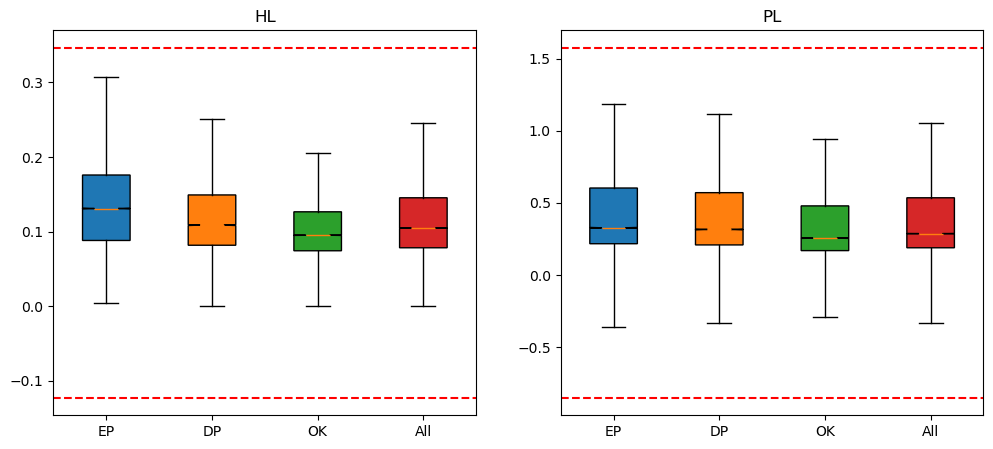

In [15]:
fig,ax = plt.subplots(figsize=(6*2,5),ncols=2)

ax = ax.flatten()

for j,key in enumerate(["HL","PL"]):
    statistics = Percentile(dataset[key])
    bs = boxplot_statistics(
        statistics,
        threshold_based_on_IQR=3,
        showfliers=False,
    )
    print(f"Percentage of inlier in {key} => {bs['inlier_percentage']}")
    #print(f"Percentage of outlier less than the lower in {key} => {(bs['outliers']<bs['lower']).sum()/len(statistics)}")
    #print(f"Percentage of outlier greater than the upper in {key} => {(bs['outliers']>bs['upper']).sum()/len(statistics)}")
    print(
        "Percentages in EP: lower: {} || upper: {}".format(
            *extract_outlier_percentage(dataset["d1"]["ailed"][key],lower=bs["lower"],upper=bs["upper"])
        )
    )

    print(
        "Percentages in DP: lower: {} || upper: {}".format(
            *extract_outlier_percentage(dataset["d2"]["ailed"][key],lower=bs["lower"],upper=bs["upper"])
        )
    )

    print(
        "Percentages in Control: lower: {} || upper: {}".format(
            *extract_outlier_percentage(
                np.concatenate((dataset["d1"]["controlled"][key],dataset["d2"]["controlled"][key])),
                lower=bs["lower"],upper=bs["upper"])
        )
    )
    print("######################")
    bplot = ax[j].boxplot(
        [
            dataset["d1"]["ailed"][key],
            dataset["d2"]["ailed"][key],
            np.concatenate((dataset["d1"]["controlled"][key],dataset["d2"]["controlled"][key])),
            dataset[key]
        ],
        notch = True,
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=["EP","DP","OK","All"],
        showfliers=False
    )  # will be used to label x-ticks
    ax[j].axhline(bs["upper"], c='r',ls="--")
    ax[j].axhline(bs["lower"], c='r',ls="--")

    ax[j].set_title(key)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [16]:
def pipeline(key,plot=False,*args,**kwds):
    statistics = Percentile(dataset[key])
    bs = boxplot_statistics(
        statistics,
        *args,
        **kwds
    )
    print(f"Percentage of inlier in {key} => {bs['inlier_percentage']}")
    print(
        "Percentages in EP: lower: {} || upper: {}".format(
            *extract_outlier_percentage(dataset["d1"]["ailed"][key],lower=bs["lower"],upper=bs["upper"])
        )
    )

    print(
        "Percentages in DP: lower: {} || upper: {}".format(
            *extract_outlier_percentage(dataset["d2"]["ailed"][key],lower=bs["lower"],upper=bs["upper"])
        )
    )

    print(
        "Percentages in Control: lower: {} || upper: {}".format(
            *extract_outlier_percentage(
                np.concatenate((dataset["d1"]["controlled"][key],dataset["d2"]["controlled"][key])),
                lower=bs["lower"],upper=bs["upper"])
        )
    )
    print(
        "Percentages in All: lower: {} || upper: {}".format(
            *extract_outlier_percentage(dataset[key],lower=bs["lower"],upper=bs["upper"])
        )
    )
    if not plot:
        return statistics,bs
    fig,ax = plt.subplots(figsize=(6*2,5))
    bplot = ax.boxplot(
        [
            dataset["d1"]["ailed"][key],
            dataset["d2"]["ailed"][key],
            np.concatenate((dataset["d1"]["controlled"][key],dataset["d2"]["controlled"][key])),
            dataset[key]
        ],
        notch = True,
        vert=True,  # vertical box alignment
        patch_artist=True,  # fill with color
        labels=["EP","DP","OK","All"],
        showfliers=False
    )  # will be used to label x-ticks
    ax.axhline(bs["upper"], c='r',ls="--")
    ax.axhline(bs["lower"], c='r',ls="--")

    ax.set_title(key)
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    return statistics,bs

Percentage of inlier in HL => 0.9868516672018387
Percentages in EP: lower: 0.0 || upper: 1.1271790808240887
Percentages in DP: lower: 0.0028632784538296352 || upper: 1.403006442376521
Percentages in Control: lower: 0.0 || upper: 1.3831589004212446
Percentages in All: lower: 0.0005633390230574663 || upper: 1.3142699407930687
[5.4759997e-01 5.4769999e-01 5.4780000e-01 ... 1.4631729e+09 1.4631729e+09
 1.4631729e+09]


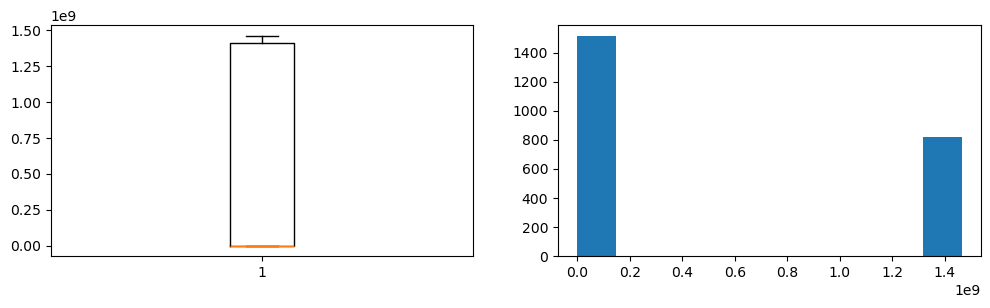

In [17]:
statistics,item = pipeline("HL",lower=0,upper_threshold_based_on_IQR=6.)
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
print(np.sort(dataset["HL"][dataset["HL"]>item["upper"]]))
ax[0].boxplot(dataset["HL"][dataset["HL"]>item["upper"]]);
ax[1].hist(dataset["HL"][dataset["HL"]>item["upper"]]);

In [18]:
item

{'med': 0.1047,
 'q1': 0.0784,
 'q3': 0.1454,
 'whislo': -0.022100001573562622,
 'whishi': 0.2459000051021576,
 'lower': 0,
 'upper': 0.5474000126123428,
 'inlier_mask': array([False,  True,  True, ..., False, False, False]),
 'inlier_percentage': 0.9868516672018387}

Percentage of inlier in PL => 0.9633646566740136
Percentages in EP: lower: 1.8416461819046863 || upper: 1.5006740147490287
Percentages in DP: lower: 2.085900117475144 || upper: 2.060112890748116
Percentages in Control: lower: 2.0064746013123016 || upper: 1.650154260635293
Percentages in All: lower: 1.9752306972496716 || upper: 1.688303635348963
[4.6988001e+00 4.6992998e+00 4.7019000e+00 ... 1.4631729e+09 1.4631729e+09
 1.4631729e+09]


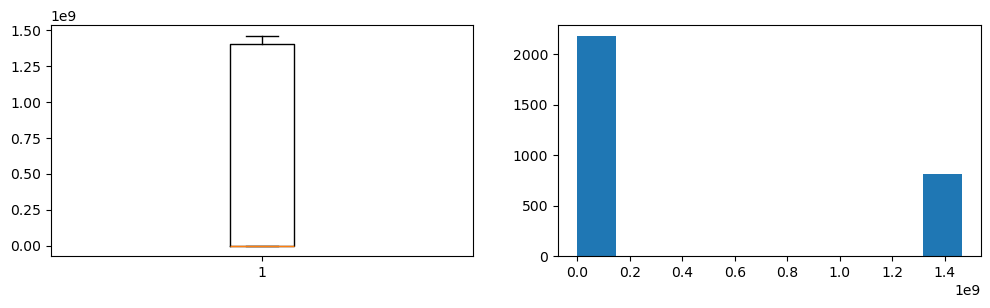

In [19]:
statistics,item = pipeline("PL",lower=0,upper_threshold_based_on_IQR=12)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
print(np.sort(dataset["PL"][dataset["PL"]>item["upper"]]))
ax[0].boxplot(dataset["PL"][dataset["PL"]>item["upper"]]);
ax[1].hist(dataset["PL"][dataset["PL"]>item["upper"]]);

Percentage of inlier in PL => 0.9762622817747764
Percentages in EP: lower: 0.582824518277694 || upper: 1.5006740147490287
Percentages in DP: lower: 0.6389501733474685 || upper: 2.060112890748116
Percentages in Control: lower: 0.7593534089427715 || upper: 1.650154260635293
Percentages in All: lower: 0.6854681871734021 || upper: 1.688303635348963
[-1.8968000e+00 -1.9068000e+00 -1.9127001e+00 ... -1.4631729e+09
 -1.4631729e+09 -1.4631729e+09]


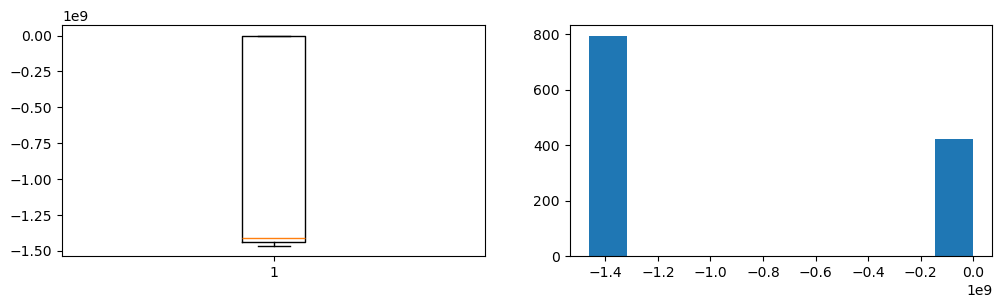

In [20]:
statistics,item = pipeline("PL",lower_threshold_based_on_IQR=6,upper_threshold_based_on_IQR=12)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
print(np.sort(dataset["PL"][dataset["PL"]<item["lower"]],)[::-1])
ax[0].boxplot(dataset["PL"][dataset["PL"]<item["lower"]]);
ax[1].hist(dataset["PL"][dataset["PL"]<item["lower"]]);

In [21]:
item

{'med': 0.2868,
 'q1': 0.1885,
 'q3': 0.5354,
 'whislo': -0.33184997737407684,
 'whishi': 1.0557499527931213,
 'lower': -1.8928999155759811,
 'upper': 4.698199808597565,
 'inlier_mask': array([False, False, False, ..., False, False, False]),
 'inlier_percentage': 0.9762622817747764}

In [26]:
r = np.where(dataset["PL"]<-1.8928999155759811)[0]


array([ -16,  -50,  -88, ...,  -17,  -71, -162])

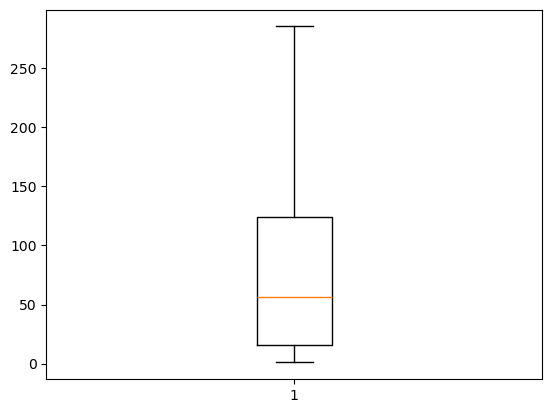

In [34]:
plt.boxplot(r[1:]-r[:-1],showfliers=False);

/home/reza/miniconda3/envs/v3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


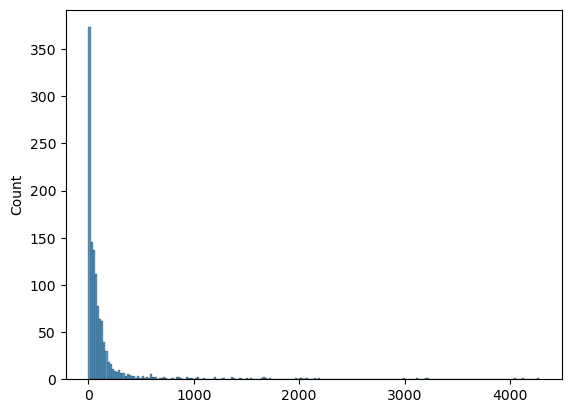

In [32]:
sns.histplot(r[1:]-r[:-1]);

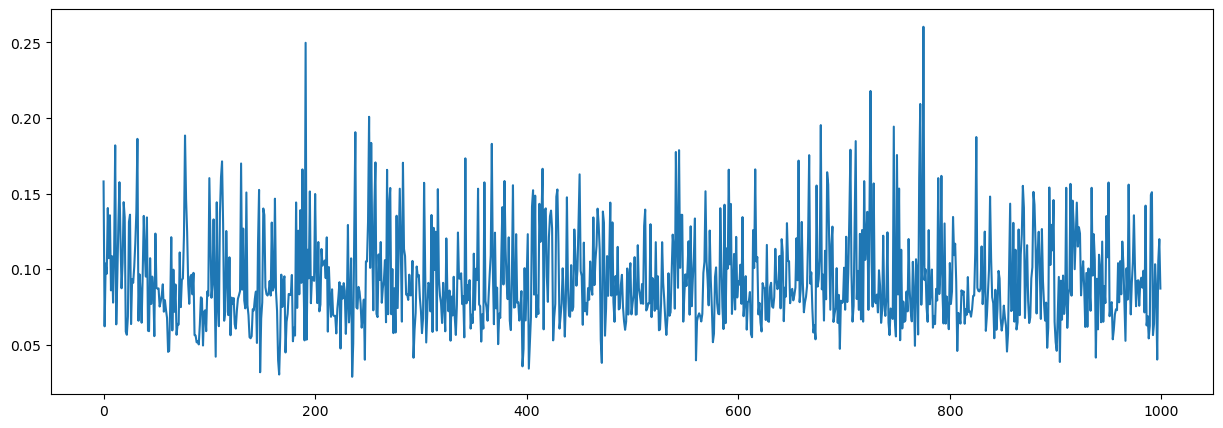

In [22]:
plt.figure(figsize=(15,5))
plt.plot(dataset["HL"][:1000])